In [1]:
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import seaborn as sns

from netam.common import print_parameter_count

from netam import framework, models

In [2]:
train_df, val_df = framework.load_shmoof_dataframes("/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv", val_nickname="small") #, sample_count=5000)

In [3]:
kmer_length = 5
site_count = 500
l2_regularization_coeff = 1e-6

train_dataset = framework.SHMoofDataset(train_df, kmer_length=kmer_length, site_count=site_count)
val_dataset = framework.SHMoofDataset(val_df, kmer_length=kmer_length, site_count=site_count)

print(f"we have {len(train_dataset)} training examples and {len(val_dataset)} validation examples")

we have 46391 training examples and 2625 validation examples


### Our "reshmoof" fitting of the shmoof model has good agreement with the original fit

In [4]:
model = models.SHMoofModel(kmer_length=kmer_length, site_count=site_count)
print_parameter_count(model)
burrito = framework.SHMBurrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, l2_regularization_coeff=l2_regularization_coeff)
losses = burrito.train(epochs=100)
model.write_shmoof_output("_ignore/reshmoof")

kmer_embedding: 1025 parameters
log_site_rates: 500 parameters
-----
total: 1525 parameters


Epoch:  32%|███▏      | 32/100 [00:39<01:22,  1.22s/it, loss_diff=2.192e-07, lr=3.2e-5, val_loss=0.05569]  


In [5]:
def plot_motif_mutabilities(shmoof_motifs, reshmoof_motifs):
    # Merge dataframes
    merged_motifs = pd.merge(shmoof_motifs, reshmoof_motifs, on='Motif', how='inner', suffixes=('_shmoof', '_reshmoof'))

    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(merged_motifs['Mutability_shmoof'], merged_motifs['Mutability_reshmoof'], alpha=0.5)

    # Determine bounds for y=x line
    min_bound = min(merged_motifs['Mutability_shmoof'].min(), merged_motifs['Mutability_reshmoof'].min())
    max_bound = max(merged_motifs['Mutability_shmoof'].max(), merged_motifs['Mutability_reshmoof'].max())

    # Add y=x line
    plt.plot([min_bound, max_bound], [min_bound, max_bound], 'r--')

    plt.xlabel('Shmoof Mutability')
    plt.ylabel('Reshmoof Mutability')
    plt.title('Comparison of Motif Mutabilities: Shmoof vs. Reshmoof')
    plt.grid(True)
    plt.show()

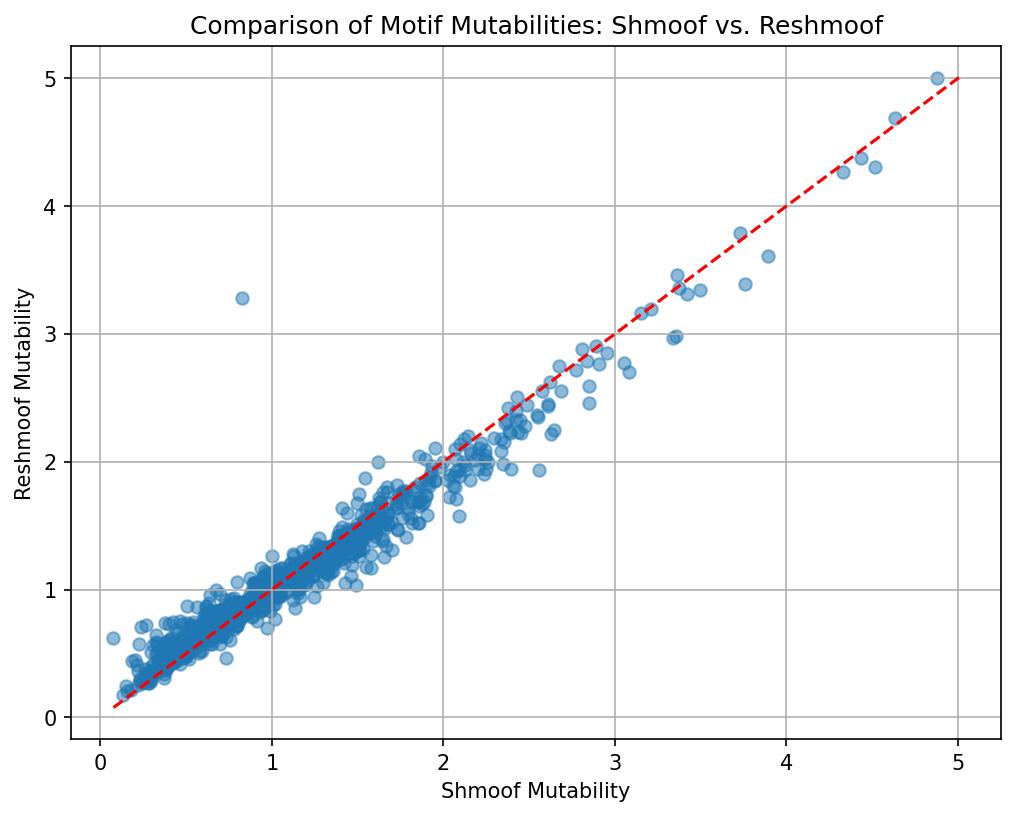

In [7]:
# Load motif mutabilities
shmoof_motifs = pd.read_csv('_ignore/original_shmoof/mutabilities_context.tsv', sep='\t')
# reshmoof_motifs = pd.read_csv('_ignore/reshmoof/motif_mutabilities.tsv', sep='\t')
reshmoof_mutabilities = torch.exp(model.kmer_embedding.weight).squeeze().detach().numpy()
reshmoof_motifs = pd.DataFrame({'Mutability': reshmoof_mutabilities, 'Motif': train_dataset.encoder.kmer_to_index.keys()})

plot_motif_mutabilities(shmoof_motifs, reshmoof_motifs)

In [8]:
def plot_position_mutabilities(shmoof_positions, reshmoof_positions):
    merged_positions = pd.merge(shmoof_positions, reshmoof_positions, on='Position', suffixes=('_shmoof', '_reshmoof'))
    merged_positions.sort_values(by='Position', inplace=True)

    # Line plot
    plt.figure(figsize=(10, 6))
    plt.plot(merged_positions['Position'], merged_positions['Mutability_shmoof'], label='Shmoof')
    plt.plot(merged_positions['Position'], merged_positions['Mutability_reshmoof'], label='Reshmoof')
    plt.xlabel('Position')
    plt.ylabel('Mutability')
    #plt.ylim(0, 5)

    plt.title('Comparison of Position Mutabilities: Shmoof vs. Reshmoof')
    plt.legend()
    plt.grid(True)
    plt.show()


We have a slight amount of regularization, which smooths out the per-site mutability when the data is weak.

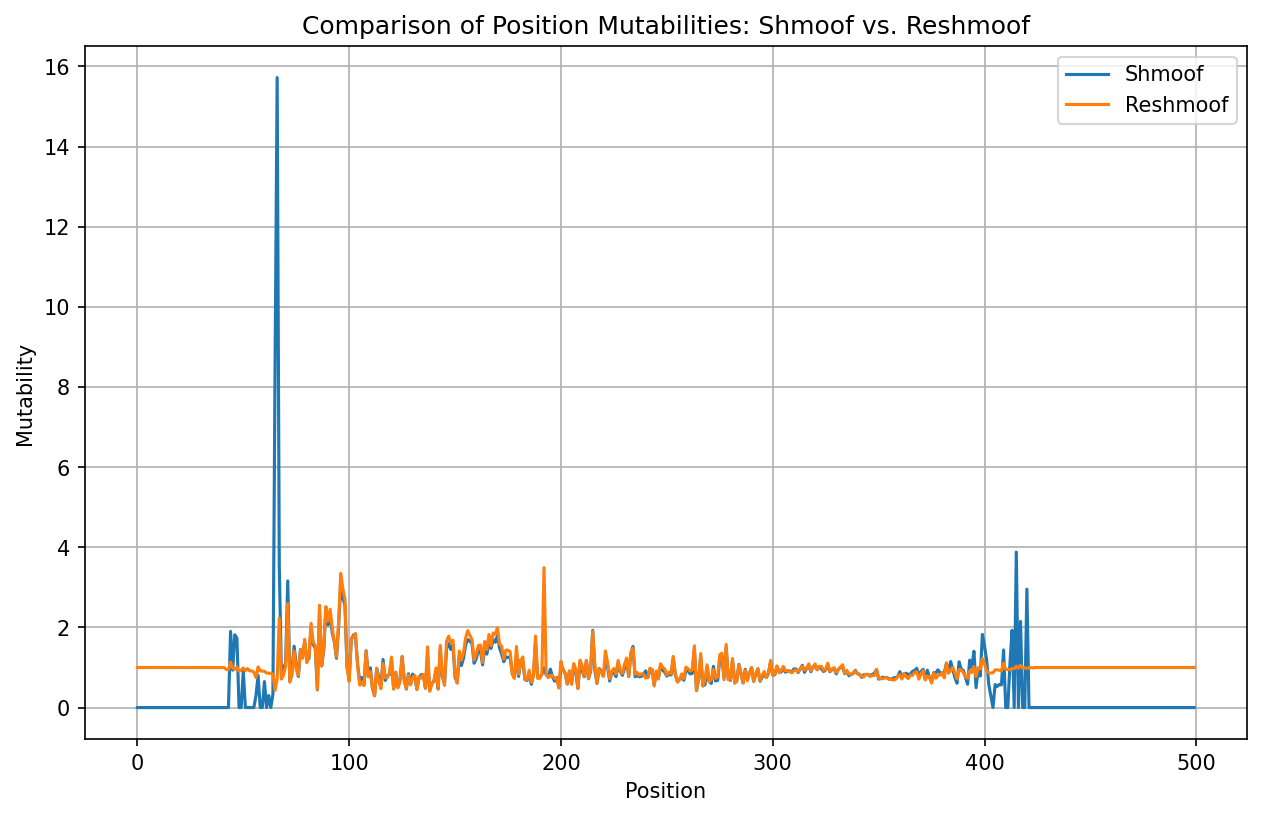

In [9]:
shmoof_positions = pd.read_csv('_ignore/original_shmoof/mutabilities_position.tsv', sep='\t')
shmoof_positions["Position"] -= 1
reshmoof_positions = torch.exp(model.log_site_rates.weight).squeeze().detach().numpy()
reshmoof_positions = pd.DataFrame({'Position': np.arange(len(reshmoof_positions)), 'Mutability': reshmoof_positions})
plot_position_mutabilities(shmoof_positions, reshmoof_positions)

### Taking the average of the k-mer based sitewise mutability shows a pattern similar to the original sitewise mutability

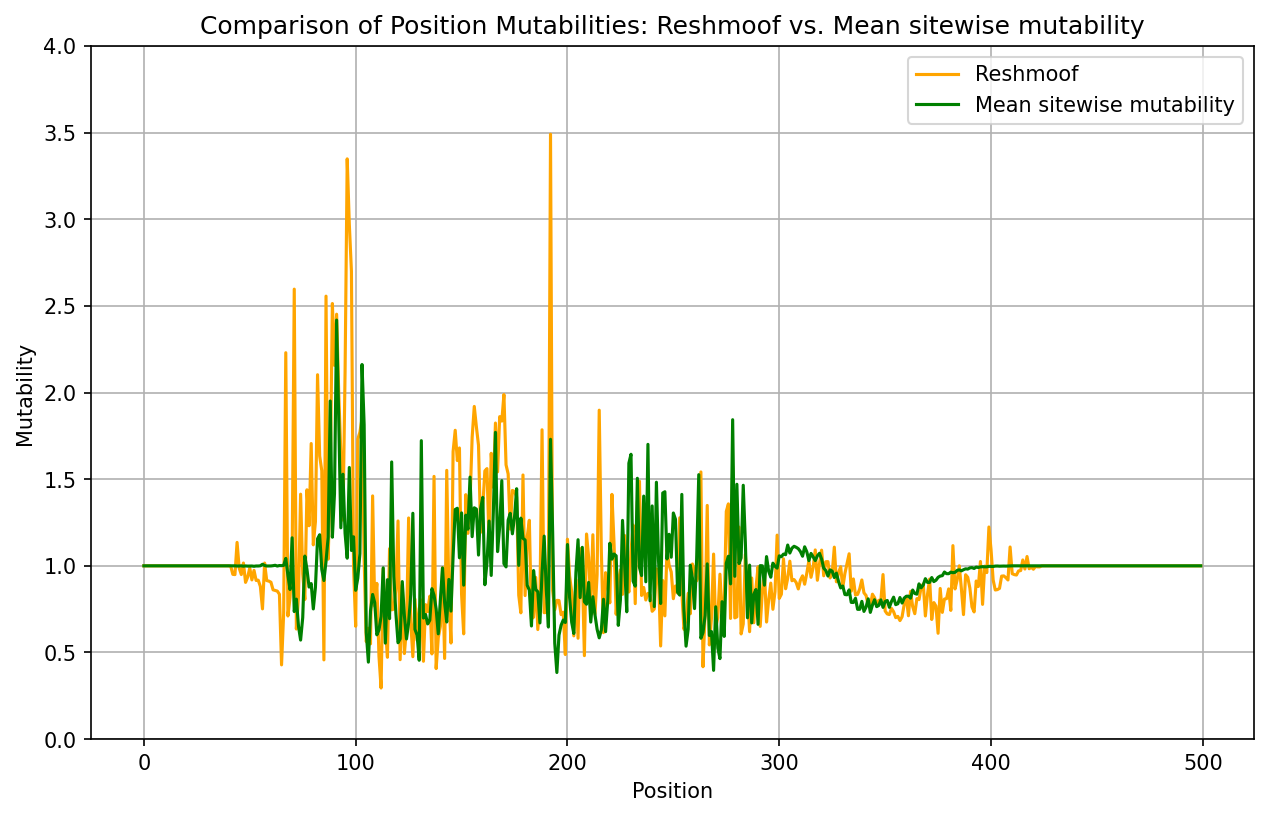

In [10]:
kmer_mutabilities = []

merged_positions = pd.merge(shmoof_positions, reshmoof_positions, on='Position', suffixes=('_shmoof', '_reshmoof'))
merged_positions.sort_values(by='Position', inplace=True)

# turn reshmoof_motifs into a dict mapping "Motif" to "Mutability"
reshmoof_motifs_dict = dict(zip(reshmoof_motifs["Motif"], reshmoof_motifs["Mutability"]))

for parent in train_df["parent"]:
    kmer_mutability = np.ones(500)
    padded_parent = "NN" + parent + "NN"
    for i in range(min(410, len(padded_parent) - 5)):
        kmer_mutability[i] = reshmoof_motifs_dict.get(padded_parent[i:i+5], 1.0)
    kmer_mutabilities.append(kmer_mutability)

[kmer_mutability.shape for kmer_mutability in kmer_mutabilities]

mean_sitewise_mutability = np.stack(kmer_mutabilities).mean(axis=0)
mean_sitewise_mutability = pd.Series(mean_sitewise_mutability)

plt.figure(figsize=(10, 6))
plt.plot(merged_positions['Position'], merged_positions['Mutability_reshmoof'], label='Reshmoof', color='orange')
plt.plot(merged_positions['Position'], mean_sitewise_mutability, label='Mean sitewise mutability', color='green')
# plt.xlim(75, 200)
plt.ylim(0, 4)
plt.xlabel('Position')
plt.ylabel('Mutability')
plt.title('Comparison of Position Mutabilities: Reshmoof vs. Mean sitewise mutability')
plt.legend()
plt.grid(True)
plt.show()

### We still get a per-site signal even if we fit the kmer component first

In [11]:
def set_requires_grad(model, attr_name, value):
    for param in getattr(model, attr_name).parameters():
        param.requires_grad = value

with torch.no_grad():
    model.log_site_rates.weight.data.zero_()

epochs = 100

model = models.SHMoofModel(kmer_length=kmer_length, site_count=site_count)
burrito = framework.SHMBurrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, l2_regularization_coeff=l2_regularization_coeff)

# First train the kmer embedding...
set_requires_grad(model, 'kmer_embedding', True)
set_requires_grad(model, 'log_site_rates', False)

burrito.train(epochs=epochs)

kmer_embedding_stored = model.kmer_embedding.weight.data.clone()

# ...then train the log site rates, fixing the kmer embedding.
# We make a new burrito because we want a new optimizer and scheudler.
burrito = framework.SHMBurrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, l2_regularization_coeff=l2_regularization_coeff)
# We get a slightly better fit by decreasing the learning rate.
set_requires_grad(model, 'kmer_embedding', False)
set_requires_grad(model, 'log_site_rates', True)

loss_history = burrito.train(epochs=epochs)

# Double check that the second round of training didn't change the kmer embedding
assert torch.allclose(kmer_embedding_stored, model.kmer_embedding.weight.data)

loss_history.tail()

Epoch:  32%|███▏      | 32/100 [00:18<00:39,  1.72it/s, loss_diff=1.79e-07, lr=3.2e-5, val_loss=0.05688]   


,train_loss,val_loss
28,0.061903,0.056883
29,0.061903,0.056883
30,0.061903,0.056882
31,0.061904,0.056882
32,0.061904,0.056883


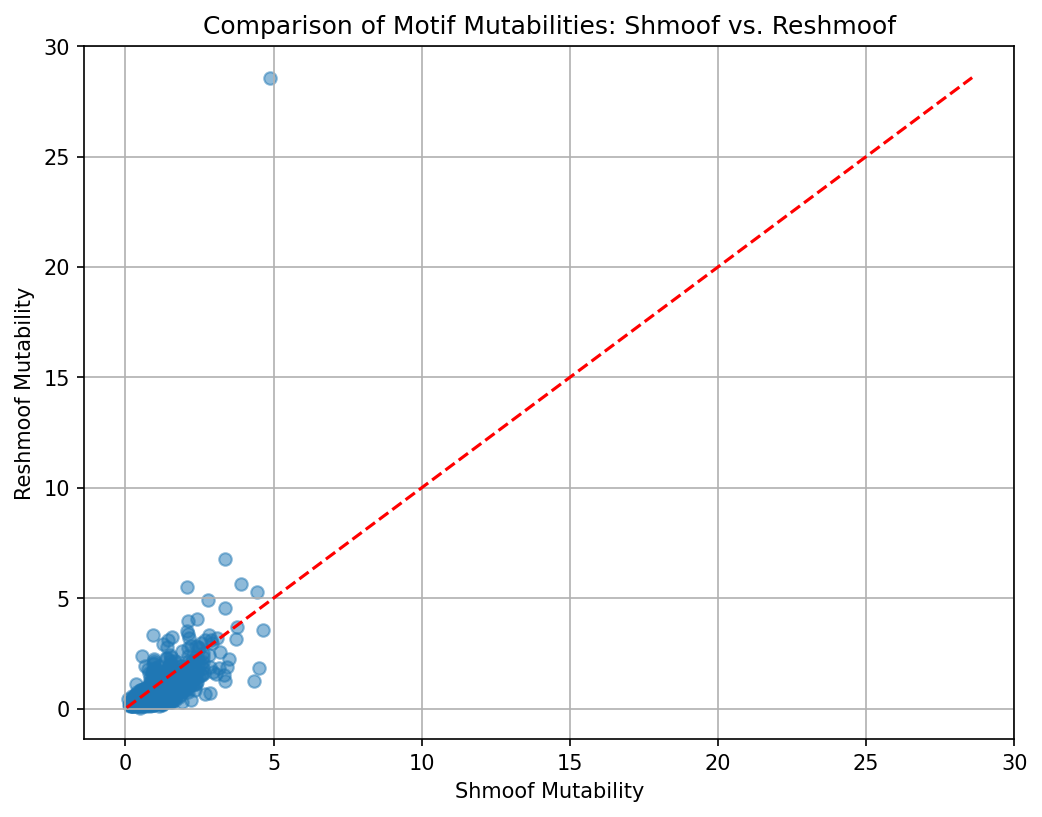

In [13]:
reshmoof_mutabilities = torch.exp(model.kmer_embedding.weight).squeeze().detach().numpy()
reshmoof_motifs = pd.DataFrame({'Mutability': reshmoof_mutabilities, 'Motif': train_dataset.encoder.kmer_to_index.keys()})

plot_motif_mutabilities(shmoof_motifs, reshmoof_motifs)


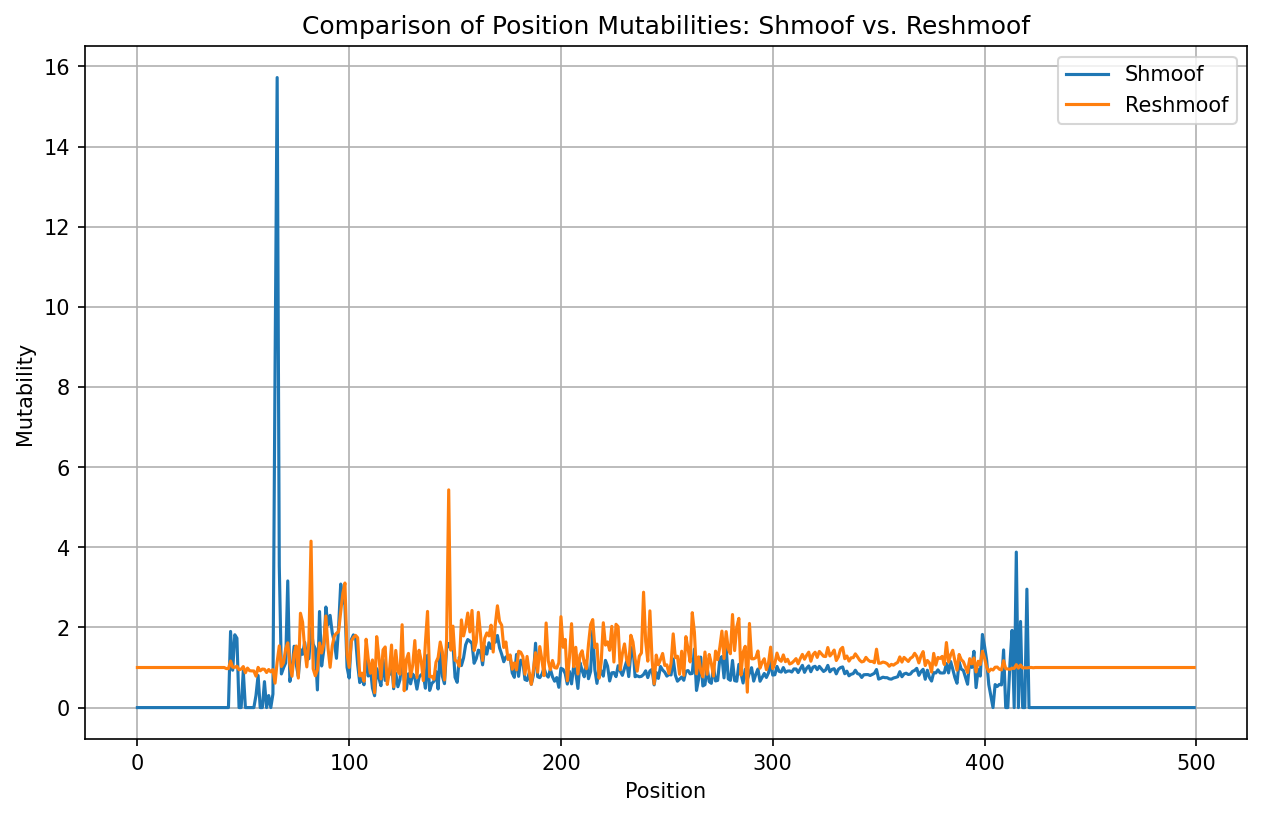

In [14]:
reshmoof_positions = torch.exp(model.log_site_rates.weight).squeeze().detach().numpy()
reshmoof_positions = pd.DataFrame({'Position': np.arange(len(reshmoof_positions)), 'Mutability': reshmoof_positions})
plot_position_mutabilities(shmoof_positions, reshmoof_positions)

Training with regularization coefficient 0


Epoch: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it, loss_diff=-6.135e-05, lr=0.1]


Training with regularization coefficient 1e-08


Epoch: 100%|██████████| 20/20 [00:25<00:00,  1.29s/it, loss_diff=2.097e-05, lr=0.004]


Training with regularization coefficient 1e-07


Epoch: 100%|██████████| 20/20 [00:25<00:00,  1.27s/it, loss_diff=5.188e-06, lr=0.02] 


Training with regularization coefficient 1e-06


Epoch: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it, loss_diff=-9.868e-06, lr=0.02]


Training with regularization coefficient 1e-05


Epoch: 100%|██████████| 20/20 [00:25<00:00,  1.27s/it, loss_diff=1.161e-06, lr=0.0008]


Training with regularization coefficient 0.0001


Epoch: 100%|██████████| 20/20 [00:25<00:00,  1.27s/it, loss_diff=2.195e-06, lr=0.004] 


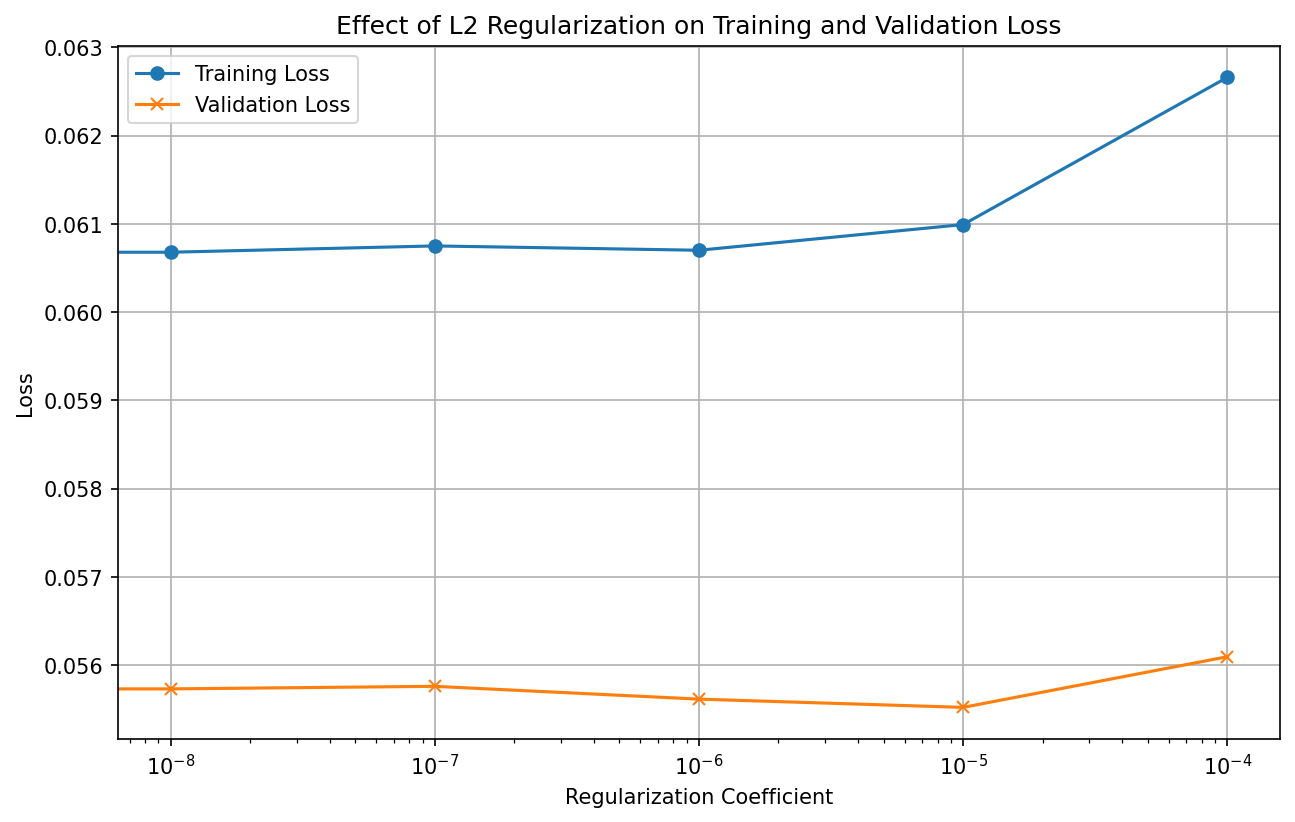

,Regularization,Final_Training_Loss,Final_Validation_Loss
0,0.000000e+00,0.060974,0.055942
1,1.000000e-08,0.060680,0.055731
2,1.000000e-07,0.060751,0.055760
3,1.000000e-06,0.060702,0.055615
4,1.000000e-05,0.060993,0.055521
5,1.000000e-04,0.062661,0.056095


In [ ]:
regularization_coeffs = [0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
results = []

for coeff in regularization_coeffs:
    print(f"Training with regularization coefficient {coeff}")
    model = models.SHMoofModel(kmer_length=kmer_length, site_count=site_count)
    burrito = framework.SHMBurrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, l2_regularization_coeff=coeff)
    loss_history = burrito.train(epochs=20)
    final_training_loss = loss_history['train_loss'].iloc[-1]
    final_validation_loss = loss_history['val_loss'].iloc[-1]

    results.append({
        'Regularization': coeff,
        'Final_Training_Loss': final_training_loss,
        'Final_Validation_Loss': final_validation_loss
    })

regularization_results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Training_Loss'], label='Training Loss', marker='o')
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Validation_Loss'], label='Validation Loss', marker='x')

plt.xscale('log')
plt.xlabel('Regularization Coefficient')
plt.ylabel('Loss')
plt.title('Effect of L2 Regularization on Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

regularization_results_df